# Tutorial 12: The Reaction-Ensemble Method

# TODO QUESTIONS

* ionization degree or degree of dissociation
* really `PROB_REACTION` in sampling loop?
* statistical uncertainty important ?

## Introduction

This tutorial introduces the basic features for simulating titratable systems via the constant pH method.
The constant pH method is one of the methods implemented for simulating systems with chemical reactions within the Reaction Ensemble module. It is a Monte Carlo method designed to model an acid-base ionization reaction at a given (fixed) value of solution pH.

We will consider a homogeneous aqueous solution of a titratable acidic species $\mathrm{HA}$ that can dissociate in a reaction, that is characterized by the equilibrium constant $\mathrm{p}K_A=-\log_{10} K_A$
$$\mathrm{HA} \Leftrightarrow \mathrm{A}^- + \mathrm{H}^+$$


If $N_0 = N_{\mathrm{HA}} + N_{\mathrm{A}^-}$ is the number of titratable groups in solution, then we define the degree of dissociation $\alpha$ as:

$$\alpha = \dfrac{N_{\mathrm{A}^-}}{N_0}.$$

This is one of the key quantities that can be used to describe the acid-base equilibrium. Usually, the goal of the simulation is to predict the value of $\alpha$ under given conditions in a complex system with interactions.

### The Chemical Equilibrium and Reaction Constant

The equilibrium reaction constant describes the chemical equilibrium of a given reaction. The values of equilibrium constants for various reactions can be found in tables. For the acid-base ionization reaction, the equilibrium constant is conventionally called the acidity constant, and it is defined as
\begin{equation}
K_A = \frac{a_{\mathrm{H}^+} a_{\mathrm{A}^-} } {a_{\mathrm{HA}}}
\end{equation}
where $a_i$ is the activity of species $i$. The activity $a_i$ is related to the chemical potential $\mu_i$ and to the concentration $c_i$
\begin{equation}
\mu_i = \mu_i^\mathrm{ref} + k_{\mathrm{B}}T \ln a_i
\,,\qquad
a_i = \frac{c_i \gamma_i}{c^{\ominus}}\,,
\end{equation}
where $\gamma_i$ is the activity coefficient, and $c^{\ominus}$ is the (arbitrary) reference concentration, often chosen to be the standard concentration, $c^{\ominus} = 1\,\mathrm{mol/L}$, and $\mu_i^\mathrm{ref}$ is the reference chemical potential.
Note that $K$ is a dimensionless quantity but its numerical value depends on the choice of $c^{\ominus}$.
For an ideal system, $\gamma_i=1$ by definition, whereas for an interacting system $\gamma_i$ is a non-trivial function of the interactions. For an ideal system we can rewrite $K$ in terms of equilibrium concentrations
\begin{equation}
K_A \overset{\mathrm{ideal}}{=} \frac{c_{\mathrm{H}^+} c_{\mathrm{A}^-} } {c_{\mathrm{HA}} c^{\ominus}}
\end{equation}

The ionization degree $\alpha$ can also be expressed via the ratio of concentrations:
\begin{equation}
\alpha 
= \frac{N_{\mathrm{A}^-}}{N_0} 
= \frac{N_{\mathrm{A}^-}}{N_{\mathrm{HA}} + N_{\mathrm{A}^-}}
= \frac{c_{\mathrm{A}^-}}{c_{\mathrm{HA}}+c_{\mathrm{A}^-}}
= \frac{c_{\mathrm{A}^-}}{c_{\mathrm{A}}}.
\end{equation}
where $c_{\mathrm{A}}=c_{\mathrm{HA}}+c_{\mathrm{A}^-}$ is the total concentration of titratable acid groups irrespective of their ionization state.
Then, we can characterize the acid-base ionization equilibrium using the ionization degree and pH, defined as
\begin{equation}
\mathrm{pH} = -\log_{10} a_{\mathrm{H^{+}}} \overset{\mathrm{ideal}}{=} -\log_{10} (c_{\mathrm{H^{+}}} / c^{\ominus})
\end{equation}
Substituting for the ionization degree and pH into the expression for $K_A$ we obtain the Henderson-Hasselbalch equation
\begin{equation}
\mathrm{pH}-\mathrm{p}K_A = \log_{10} \frac{\alpha}{1-\alpha}
\end{equation}
One result of the Henderson-Hasselbalch equation is that at a fixed pH value the ionization degree of an ideal acid is independent of concentration. Another implication is, that the degree of ionization does not depend on the absolute values of $\mathrm{p}K_A$ and $\mathrm{pH}$, but only on their difference, $\mathrm{pH}-\mathrm{p}K_A$.
Therefore, for an ideal system, the ionization degree $\alpha$ can be obtained from the equation via the simple function:

In [1]:
# ionization degree alpha calculated from the Henderson-Hasselbalch equation for an ideal system
def ideal_alpha(pH, pK):
    return 1. / (1 + 10**(pK - pH))

### Constant pH Method

The constant pH method [Reed1992](https://doi.org/10.1063/1.462145) is designed to simulate an acid-base ionization reaction at a given pH. It assumes that the simulated system is coupled to an implicit reservoir of $\mathrm{H^+}$ ions but exchange of ions with this reservoir is not explicitly simulated. Therefore, the concentration of ions in the simulation box is not equal to the concentration of $\mathrm{H^+}$ ions at the chosen pH. This may lead to artifacts when simulating interacting systems, especially at high of low pH values. Discussion of these artifacts is beyond the scope of this tutorial (see e.g. [Landsgesell2019](https://doi.org/10.1039/C8SM02085J) for further details).

In ESPResSo, the forward step of the ionization reaction (from left to right) is implemented by 
changing the chemical identity (particle type) of a randomly selected $\mathrm{HA}$ particle to $\mathrm{A}^-$, and inserting another particle that represents a neutralizing counterion. The neutralizing counterion is not necessarily an $\mathrm{H^+}$ ion. Therefore, we give it a generic name $\mathrm{B^+}$. In the reverse direction (from right to left), the chemical identity (particle type) of a randomly selected $\mathrm{A}^{-}$ is changed to $\mathrm{HA}$, and a randomly selected $\mathrm{B}^+$ is deleted from the simulation box. The probability of proposing the  forward reaction step is $P_\text{prop}=N_\mathrm{HA}/N_0$, and probability of proposing the reverse step is $P_\text{prop}=N_\mathrm{A}/N_0$. The trial move is accepted with the acceptance probability

$$ P_{\mathrm{acc}} = \operatorname{min}\left(1, \exp(-\beta \Delta E_\mathrm{pot} \pm \ln(10) \cdot (\mathrm{pH - p}K_A) ) \right)$$

Here $\Delta E_\text{pot}$ is the potential energy change due to the reaction, while $\text{pH - p}K$ is an input parameter. 
The signs $\pm 1$ correspond to the forward and reverse direction of the ionization reaction, respectively. 



## Setup

First we import all necessary modules including ESPResSo for simulations and others for convenience.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pint  # module for working with units and dimensions

import espressomd
from espressomd import electrostatics, polymer, reaction_ensemble
from espressomd.interactions import HarmonicBond

The package [pint](https://pint.readthedocs.io/en/stable/) is intended to make handling physical quantities with different units easy. You simply create an instance of <tt>[pint.UnitRegistry](https://pint.readthedocs.io/en/stable/developers_reference.html?highlight=UnitRegistry#pint.UnitRegistry)</tt> and access its unit definitions and automatic conversions. For more information or a quick introduction please look at the [pint-documentation](https://pint.readthedocs.io/en/stable/) or [pint-tutorials](https://pint.readthedocs.io/en/stable/tutorial.html#tutorial).

In [3]:
ureg = pint.UnitRegistry()

The inputs that we need to define our system in the simulation include

* temperature `TEMPERATURE`
* relative permittivity of water `WATER_PERMITTIVITY`
* Bjerrum length `BJERRUM_LENGTH` 
* concentration of the titratable units `C_ACID`
* system size (given by the number of titratable units) `N_ACID`
* concentration of added salt `C_SALT`
* dissociation constant `pK`
* pH
* types of non-bonded interactions we want to use 
* particle types `TYPES` and charges `CHARGES` and their mapping to espresso

#### Set energy- and length scale

First we define the physical/real temperature `TEMPERATURE`. As we simulate the water only implicitly, its corresponding relative permmitivity `WATER_PERMITTIVITY` is needed. With those two values the bjerrum-length of the system `BJERRUM_LENGTH` can be calculated.

To map the physical units to simulation units we define some new units in `ureg`. We choose our energy unit as $\Delta E = 1 k_\mathrm{B}T$ and as a length scale we choose $\Delta x = \frac{1}{2} \lambda_\mathrm{B} \approx 0.355 \mathrm{nm}$, as this is a common choice for atomic radii in course grained simulations.

In [4]:
TEMPERATURE = 300 * ureg.kelvin
KT = TEMPERATURE * ureg.boltzmann_constant
WATER_PERMITTIVITY = 80
BJERRUM_LENGTH = ureg.elementary_charge**2 / (4 * ureg.pi * ureg.vacuum_permittivity * WATER_PERMITTIVITY * KT)

ureg.define(f'sim_energy = {TEMPERATURE} * boltzmann_constant')
ureg.define(f'sim_length = 0.5 * {BJERRUM_LENGTH}')

#### Set concentrations and system size

Next we define the concentration-constants in the system, which are the concentration of titratable units `C_ACID` and the salt `C_SALT`, as well as the total number of titratable units `N_ACID`.

From both the concentration and the number of titratable units we can calculate the box volume `BOX_V`. With our choice of a cubic simulation box we can subsequently determine the box length `BOX_L`.
The chosen salt concentration and the box volume set the number of additional salt ion pairs `N_SALT` that should be present in the system.

In [5]:
C_ACID = 1e-3 * ureg.molar
C_SALT = 2 * C_ACID
N_ACID = 20

BOX_V = (N_ACID / (ureg.avogadro_constant * C_ACID)).to("sim_length^3")
BOX_L = BOX_V ** (1 / 3)
BOX_L_DIMENSIONLESS = BOX_L.to("sim_length").magnitude

N_SALT = int((C_SALT * BOX_V * ureg.avogadro_constant).to('dimensionless'))

C_ACID_DIMENSIONLESS = C_ACID.to('mol/L').magnitude
C_SALT_DIMENSIONLESS = C_SALT.to('mol/l').magnitude

#### Set reaction variables

We set the dissociation constant of the acid to $\mathrm{p}K_A=4.88$, that is the acidity constant of propionic acid. We choose propionic acid because its structure is closest to the repeating unit of poly(acrylic acid), the most commonly used weak polyacid.

We will simulate multiple pH values, where the range is determined by the parameters `OFFSET` and `NUM_PHS`.

In [6]:
# acidity constant
pK = 4.88
K = 10**(-pK)
pKw = 14.0  # autoprotolysis constant of water

# variables for pH sampling
NUM_PHS = 15  # number of pH values
OFFSET = 2.0  # range of pH values to be used = pK +/- offset

pHmin = pK - OFFSET  # lowest pH value to be used
pHmax = pK + OFFSET  # highest pH value to be used
pHs = np.linspace(pHmin, pHmax, NUM_PHS)  # list of pH values

#### Set non-bonded interaction flags

Here we decide what kind of non-bonded interactions we want to use. By setting `USE_WCA`to `True` the script below  creates WCA-interactions between all particles, setting `USE_ELECTROSTATICS` to `True` will result in electrostatic interactions beeing turned on. Using electrostatic interaction and differently charged particles always has to be coupled with a short-range-repulsion-interaction, commonly a WCA-interaction.

To be able to compare our results to the analytical solutions for ideal systems and to obtain results very quickly, we begin with all non-bonded interactions turned off. In the next runs, we will add the steric repulsion and electrostatic interactions to observe their effect on the ionization.

In [7]:
# Simulate an interacting system with steric repulsion (Warning: it will be slower than without WCA!)
USE_WCA = False
# Simulate an interacting system with electrostatics (Warning: it will be very slow!)
USE_ELECTROSTATICS = False

if USE_ELECTROSTATICS:
    assert USE_WCA, "You can not use electrostatics without a short range repulsive potential. Otherwise oppositely charged particles could come infeniteltly close."

#### Set number of samples

For error analysis we specify the number of blocks `N_BLOCKS` and the desired number of samples per block `DESIRED_BLOCK_SIZE`. From that we can calculate the total number of samples `num_samples`.

TODO `PROB_REACTION`

In [8]:
N_BLOCKS = 16 # number of block to be used in data analysis
DESIRED_BLOCK_SIZE = 10 # desired number of samples per block

PROB_REACTION = 0.5 # probability of accepting the reaction move. This parameter changes the speed of convergence.

# number of reaction samples per each pH value
num_samples = int(N_BLOCKS * DESIRED_BLOCK_SIZE / PROB_REACTION)

#### Set particle types and charges

Finally we have to set the particle types we want to simulate and their mapping to ESPResSo-particle-types, as well as particle charges.

In [9]:
# particle types of different species
TYPES = {
    "HA" : 0,
    "A" : 1,
    "B" : 2,
    "Na" : 3,
    "Cl" : 4,
}
# particle charges of different species
CHARGES = {
    "HA" : 0,
    "A" : -1,
    "B" : +1,
    "Na" : +1,
    "Cl" : -1,
}

### Initialize the ESPResSo system

In [10]:
system = espressomd.System(box_l=[BOX_L_DIMENSIONLESS] * 3)
system.time_step = 0.01
system.cell_system.skin = 0.4
system.thermostat.set_langevin(kT=KT.to("sim_energy").magnitude, gamma=1.0, seed=7)
np.random.seed(seed=10)  # initialize the random number generator in numpy

### Set up particles and bonded-interactinos

After defining the simulation parameters, we set up the system that we want to simulate. It is a polyelectrolyte chain with some added salt that is used to control the ionic strength of the solution. 

First we define the bond-interaction of the polymer and add the bonded interaction type to the system.
Then we create the particles. Bonded particle positions of a linear polymer can be created via the <tt>[polymer.linear_polymer_positions](http://espressomd.org/html/doc/espressomd.html#espressomd.polymer.linear_polymer_positions)</tt>, for more details see corresponding <tt>[section in the documentation](http://espressomd.org/html/doc/particles.html?highlight=polymer#setting-up-polymer-chains)</tt>. Finally we add the $\mathrm{B}^+$-ions to the system, followed by adding the salt-ion pairs to the system.

In [11]:
# we need to define bonds before creating polymers
hb = HarmonicBond(k=30, r_0=1.0)
system.bonded_inter.add(hb)

# create the polymer positions 
polymers = polymer.linear_polymer_positions(n_polymers=1,
                                            beads_per_chain=N_ACID,
                                            bond_length=0.9, seed=23)
# add the polymer particles composed of ionizable acid groups, initially in the ionized state
for local_polymer in polymers:
    start_id = len(system.part)
    for index, position in enumerate(local_polymer):
        ID = start_id + index
        system.part.add(id=ID, pos=position, type=TYPES["A"], q=CHARGES["A"])
        # create harmonic bonds between adjacent particles
        if index > 0:
            system.part[ID].add_bond((hb, ID - 1))

# add the corresponding number of H+ ions 
system.part.add(pos=np.random.random((N_ACID, 3)) * BOX_L_DIMENSIONLESS,
                type=[TYPES["B"]] * N_ACID,
                q=[CHARGES["B"]] * N_ACID)

# add salt ion pairs
system.part.add(pos=np.random.random((N_SALT, 3)) * BOX_L_DIMENSIONLESS,
                type=[TYPES["Na"]] * N_SALT,
                q=[CHARGES["Na"]] * N_SALT)
system.part.add(pos=np.random.random((N_SALT, 3)) * BOX_L_DIMENSIONLESS,
                type=[TYPES["Cl"]] * N_SALT,
                q=[CHARGES["Cl"]] * N_SALT)

### Set up non-bonded-interactinos

If the WCA-Interaction is enabled via the `USE_WCA`-flag, we activate the interaction for each type-pair in the system. Afterwards the overlaps are removed with the steepest-escent integrator and the we let system relax by calling `1000` integration steps.

Lastly we need to setup the electrostatic interaction between the particles if we enabled it via the `USE_ELECTROSTATICS`-flag. For that we use the `P3M` algorithm.

In [12]:
if USE_WCA:
    for type_1, type_2 in ((x, y) for x in TYPES.values() for y in TYPES.values()):
        system.non_bonded_inter[type_1, type_2].wca.set_params(epsilon=1.0, sigma=1.0)
    
    # relax the overlaps with steepest descent
    system.integrator.set_steepest_descent(f_max=0, gamma=0.1, max_displacement=0.1)
    system.integrator.run(20)
    system.integrator.set_vv()  # to switch back to velocity Verlet

# short integration to let the system relax
system.integrator.run(steps=1000)

if USE_ELECTROSTATICS:
    p3m = electrostatics.P3M(
        prefactor=(BJERRUM_LENGTH * KT / (ureg.elementary_charge ** 2)).to("sim_length * sim_energy / e^2").magnitude,
        accuracy=1e-3) 
    system.actors.add(p3m)
else:
    # this speeds up the simulation of dilute systems with small particle numbers
    system.cell_system.set_n_square() 

### Set up reaction-ensemble method

After the particles have been added to the system we initialize the `reaction_ensemble`. The parameters to set are:

* `temperature` specifies the $k_\mathrm{B}T$ value which is used as the inverse-temperature in the boltzmann-factor to calculate the probabilities for the insertion.
* `exclusion_radius` specifies the minimum distance between an inserted particle and the already existing particles in the system. The purpose of this value is to stabilize the MD-integration for interacting systems by eliminating the chance of strongly-overlapping particles, which would otherwise result in huge forces. If the particles are not interacting, we can set the exclusion radius to $0.0$. Otherwise, it should be similar to the distance of strong repulsion between two atoms. For our choice of WCA-paramters $1.0$ is a good value.
* `seed` for the random number generator

**Exercise:**

* Use <tt>[reaction_ensemble.ConstantpHEnsemble](http://espressomd.org/html/doc/espressomd.html?highlight=constant%20ph#espressomd.reaction_ensemble.ConstantpHEnsemble)</tt> to create an instance of the reaction-ensemble constant ph-method called `RE`

***Hint:***
* make sure to provide the `temperature` and `exlusion_radius` in simulation units!

```python
exclusion_radius = 1.0 if USE_WCA else 0.0
RE = reaction_ensemble.ConstantpHEnsemble(
    temperature=KT.to("sim_energy").magnitude, 
    exclusion_radius=exclusion_radius, 
    seed=77
)
```

In [13]:
exclusion_radius = 1.0 if USE_WCA else 0.0
RE = reaction_ensemble.ConstantpHEnsemble(
    temperature=KT.to("sim_energy").magnitude, 
    exclusion_radius=exclusion_radius, 
    seed=77
)

The next step is to define the reaction system. The order in which species are written in the lists of reactants and products is very important for ESPResSo. When a reaction move is performed, identity of the first species in the list of reactants is changed to the first species in the list of products, the second reactant species is changed to the second product species, and so on. If the reactant list has more species than the product list, then excess reactant species are deleted from the system. If the product list has more species than the reactant list, then product the excess product species are created and randomly placed inside the simulation box. This convention is especially important if some of the species belong to a chain-like molecule, and cannot be placed at an arbitrary position.

**Exercise:**

* Use <tt>[reaction_ensemble.ConstantpHEnsemble.add_reaction](http://espressomd.org/html/doc/espressomd.html?highlight=constant%20ph#espressomd.reaction_ensemble.ConstantpHEnsemble.add_reaction)</tt> to add the reaction; remember to use the variables that were set up above for the reaction constant and the particle types and charges


***Hint:*** Make sure to place `TYPES["HA"]` and `TYPES["A"]` as first elements in the `reactant_types` and `product_types` lists respectively

```python
RE.add_reaction(
      gamma=K,
      reactant_types=[TYPES["HA"]],
      reactant_coefficients=[1],
      product_types=[TYPES["A"], TYPES["B"]],
      product_coefficients=[1, 1],
      default_charges={TYPES["HA"]: CHARGES["HA"],
                       TYPES["A"]: CHARGES["A"],
                       TYPES["B"]: CHARGES["B"]}
)
```

In [14]:
RE.add_reaction(
      gamma=K,
      reactant_types=[TYPES["HA"]],
      reactant_coefficients=[1],
      product_types=[TYPES["A"], TYPES["B"]],
      product_coefficients=[1, 1],
      default_charges={TYPES["HA"]: CHARGES["HA"],
                       TYPES["A"]: CHARGES["A"],
                       TYPES["B"]: CHARGES["B"]}
)

In the example above, the order of reactants and products ensures that identity of $\mathrm{HA}$ is changed to $\mathrm{A^{-}}$ and vice versa, while $\mathrm{H^{+}}$ is inserted/deleted in the reaction move. Reversing the order of products in our reaction (i.e. from `product_types=[TYPES["A"], TYPES["B"]]` to `product_types=[TYPES["B"], TYPES["A"]]`), would result in a reaction move, where the identity $\mathrm{HA}$ would be changed to $\mathrm{H^{+}}$, while $\mathrm{A^{-}}$ would be inserted/deleted at a random position in the box. Therefore $\mathrm{H^{+}}$ would be part of the polymer chain and $\mathrm{A^{-}}$ a free floating ion. 

We also assign charges to each type because the charge will play an important role when electrostatic interactions are added to the system.

## Run Simulations

Finally, we can perform simulations at different pH values. First the pH-value of the reaction ensemble instance has to be set, then the system has to be equilibrated.



**Exercise:**

* Write a function called `equilibrate_pH()` that performes the equilibration of the pH value by performing reaction-attempts in the system by calling <tt>[RE.reaction](http://espressomd.org/html/doc/espressomd.html?highlight=constant%20ph#espressomd.reaction_ensemble.ReactionAlgorithm.reaction)</tt>.

***Hint:*** Make sure to attempt enough reactions with `reaction_steps`, which should be large compared to the number of reacting particles `N_ACID` in the system.

```python
def equilibrate_pH():
    RE.reaction(reaction_steps=20 * N_ACID + 1)
```

In [15]:
def equilibrate_pH():
    RE.reaction(reaction_steps=20 * N_ACID + 1)

Since the system can now be equilibrated, the integration/sampling loop can be written.

**Exercise:**

* Write a function called `perform_sampling()` that implements the sampling loop
* Two parameters should be taken as an input:
 * an integer value `num_samples`
 * a numpy array `numAs`, where `len(numAs) == num_samples` to store the particle number into
* The function should encorparate
 * sampling of the reaction algorithm with <tt>[RE.reaction](http://espressomd.org/html/doc/espressomd.html?highlight=constant%20ph#espressomd.reaction_ensemble.ReactionAlgorithm.reaction)</tt>
 * if the particles are interacting the standard MD-integration

* for each sample step the current number of particles of type $\mathrm{A^-}$ should be written to the corresponding index in `numAs` for analysis

***Hint:***
* for each sampling step `reaction_steps` should be at least as large as titrable units (`N_ACID`) are in the system
* the number of particles of a certain type can be obtained via the function <tt>[espressomd.system.System.number_of_particles()](http://espressomd.org/html/doc/espressomd.html#espressomd.system.System.number_of_particles)</tt>

```python
def perform_sampling(num_samples, numAs: np.ndarray):
    for i in range(num_samples):
        if np.random.random() < PROB_REACTION:
            # should be at least one reaction attempt per particle
            RE.reaction(reaction_steps=N_ACID + 1)
        if USE_WCA:
            system.integrator.run(steps=1000)
        numAs[i] = system.number_of_particles(type=TYPES["A"])
```

In [16]:
def perform_sampling(num_samples, numAs: np.ndarray):
    for i in range(num_samples):
        if np.random.random() < PROB_REACTION:
            # should be at least one reaction attempt per particle
            RE.reaction(reaction_steps=N_ACID + 1)
        if USE_WCA:
            system.integrator.run(steps=1000)
        numAs[i] = system.number_of_particles(type=TYPES["A"])

Finally we have everything together to run our simulations. We set the pH value in <tt>[RE.constant_pH](http://espressomd.org/html/doc/espressomd.html?highlight=constant_ph#espressomd.reaction_ensemble.ConstantpHEnsemble.constant_pH)</tt> and use our `equilibrate_pH` function to equilibrate the system. After that the samplings are performed with our `perform_sampling` function.

In [17]:
# empty numpy array as placeholders for collecting data
numAs_at_each_pH = -np.ones((len(pHs), num_samples))  # number of A- species observed at each sample

# run a productive simulation and collect the data
print(f"Simulated pH values: {pHs}")
for ipH,pH in enumerate(pHs):
    print(f"Run pH {pH:.2f} ...")

    RE.constant_pH = pH # set new pH value
    equilibrate_pH()  # pre-equilibrate to the new pH value
    perform_sampling(num_samples, numAs_at_each_pH[ipH, :]) # perform sampling/ run production simulation

    print(f"measured number of A-: {np.mean(numAs_at_each_pH[ipH]):.2f}, (ideal: {N_ACID*ideal_alpha(pH, pK):.2f})")

Simulated pH values: [2.88       3.16571429 3.45142857 3.73714286 4.02285714 4.30857143
 4.59428571 4.88       5.16571429 5.45142857 5.73714286 6.02285714
 6.30857143 6.59428571 6.88      ]
Run pH 2.88 ...
measured number of A-: 0.24, (ideal: 0.20)
Run pH 3.17 ...
measured number of A-: 0.39, (ideal: 0.38)
Run pH 3.45 ...
measured number of A-: 0.69, (ideal: 0.72)
Run pH 3.74 ...
measured number of A-: 1.30, (ideal: 1.34)
Run pH 4.02 ...
measured number of A-: 2.60, (ideal: 2.44)
Run pH 4.31 ...
measured number of A-: 4.21, (ideal: 4.23)
Run pH 4.59 ...
measured number of A-: 6.82, (ideal: 6.82)
Run pH 4.88 ...
measured number of A-: 10.14, (ideal: 10.00)
Run pH 5.17 ...
measured number of A-: 13.03, (ideal: 13.18)
Run pH 5.45 ...
measured number of A-: 15.52, (ideal: 15.77)
Run pH 5.74 ...
measured number of A-: 17.47, (ideal: 17.56)
Run pH 6.02 ...
measured number of A-: 18.73, (ideal: 18.66)
Run pH 6.31 ...
measured number of A-: 19.36, (ideal: 19.28)
Run pH 6.59 ...
measured number

## Results

Now we plot our results and compare them to the analytical results obtained from the Henderson-Hasselbalch equation.

### Statistical Uncertainty

The molecular simulation produces a sequence of snapshots of the system, that 
constitute a Markov chain. It is a sequence of realizations of a random process, where
the next value in the sequence depends on the preceding one. Therefore,
the subsequent values are correlated. To estimate statistical error of the averages
determined in the simulation, one needs to correct for the correlations.

Here, we will use a rudimentary way of correcting for correlations, termed the binning method.
We refer the reader to specialized literature for a more sophisticated discussion, for example [Janke2002](https://www.physik.uni-leipzig.de/~janke/Paper/nic10_423_2002.pdf). The general idea is to group a long sequence of correlated values into a rather small number of blocks, and compute an average per each block. If the blocks are big enough, they
can be considered uncorrelated, and one can apply the formula for standard error of the mean of uncorrelated values. If the number of blocks is small, then they are uncorrelated but the obtained error estimates has a high uncertainty. If the number of blocks is high, then they are too short to be uncorrelated, and the obtained error estimates are systematically lower than the correct value. Therefore, the method works well only if the sample size is much greater than the autocorrelation time, so that it can be divided into a sufficient number of mutually uncorrelated blocks.

In [18]:
# statistical analysis of the results
def block_analyze(input_data, n_blocks=16):
    data = np.asarray(input_data)
    block = 0
    # this number of blocks is recommended by Janke as a reasonable compromise
    # between the conflicting requirements on block size and number of blocks
    block_size = int(data.shape[1] // n_blocks)
    print(f"block_size: {block_size}")
    # initialize the array of per-block averages
    block_average = np.zeros((n_blocks, data.shape[0]))
    # calculate averages per each block
    for block in range(n_blocks):
        block_average[block] = np.average(data[:, block * block_size: (block + 1) * block_size], axis=1)
    # calculate the average and average of the square
    av_data = np.average(data, axis=1)
    av2_data = np.average(data * data, axis=1)
    # calculate the variance of the block averages
    block_var = np.var(block_average, axis=0)
    # calculate standard error of the mean
    err_data = np.sqrt(block_var / (n_blocks - 1))
    # estimate autocorrelation time using the formula given by Janke
    # this assumes that the errors have been correctly estimated
    tau_data = np.zeros(av_data.shape)
    for val in range(av_data.shape[0]):
        if av_data[val] == 0:
            # unphysical value marks a failure to compute tau
            tau_data[val] = -1.0
        else:
            tau_data[val] = 0.5 * block_size * n_blocks / (n_blocks - 1) * block_var[val] \
                / (av2_data[val] - av_data[val] * av_data[val])
    return av_data, err_data, tau_data, block_size

Here, we calcuate the avarge number of particles of type $\mathrm{A^-}$ and estimate the error and auto-correlation time by the statistical analysis presented before.

The degree of ionization $\alpha$ can simply be calculated by dividing the number of particales of type $\mathrm{A^-}$ by the number of titrable units `N_ACID` (see Introduction section for details). Then we can plot the degrees of ionization $\alpha$ that we obtained for different pH-values over the pH-value.

block_size: 20
av = [ 0.24375   0.3875    0.6875    1.3       2.6       4.2125    6.81875
 10.1375   13.034375 15.521875 17.465625 18.728125 19.35625  19.5125
 19.75625 ]
err = [0.07372175 0.06199798 0.13885694 0.13693064 0.22107691 0.20435366
 0.28500274 0.24266318 0.1696024  0.12331943 0.10623468 0.09453491
 0.10174263 0.06511208 0.05860798]
tau = [4.15400883 1.6685036  3.46690079 2.45398773 3.27196653 1.83444154
 2.43562544 1.92040086 0.98537743 0.83200933 0.87335887 1.52855
 2.71255838 1.77996447 2.40954501]


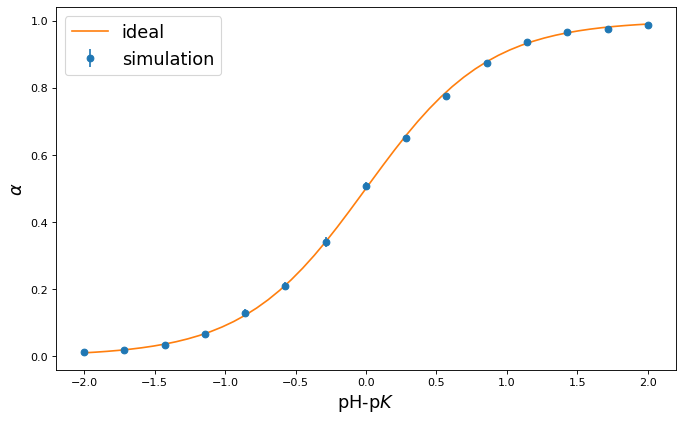

In [19]:
# estimate the statistical error and the autocorrelation time using the formula given by Janke
av_numAs, err_numAs, tau, block_size = block_analyze(numAs_at_each_pH, N_BLOCKS)
print(f"av = {av_numAs}")
print(f"err = {err_numAs}")
print(f"tau = {tau}")

# calculate the average ionization degree
av_alpha = av_numAs / N_ACID
err_alpha = err_numAs / N_ACID

# plot the simulation results compared with the ideal titration curve
plt.figure(figsize=(10, 6), dpi=80)
plt.errorbar(pHs - pK, av_alpha, err_alpha, marker='o', linestyle='none',
             label=r"simulation")
pHs2 = np.linspace(pHmin, pHmax, num=50)
plt.plot(pHs2 - pK, ideal_alpha(pHs2, pK), label=r"ideal")
plt.xlabel('pH-p$K$', fontsize=16)
plt.ylabel(r'$\alpha$', fontsize=16)
plt.legend(fontsize=16)
plt.show()

The simulation results for the non-interacting case compare very well with the analytical solution of Henderson-Hasselbalch equation. There are only minor deviations, and the estimated errors are small too. This situation will change when we introduce interactions.

It is useful to check whether the estimated errors are consistent with the assumptions that were used to obtain them. To do this, we follow [Janke2002](https://www.physik.uni-leipzig.de/~janke/Paper/nic10_423_2002.pdf) to estimate the number of uncorrelated samples per block, and check whether each block contains a sufficient number of uncorrelated samples (we choose 10 uncorrelated samples per block as the threshold value).

Intentionally, we made our simulation slightly too short, so that it does not produce enough uncorrelated samples. We encourage the reader to vary the number of blocks or the number of samples to see how the estimated error changes with these parameters.

In [20]:
# check if the blocks contain enough data for reliable error estimates
print(f"uncorrelated samples per block:\nblock_size/tau = {block_size / tau}")
threshold = 10  # block size should be much greater than the correlation time
if np.any(block_size / tau < threshold):
    print(f"\nWarning: some blocks may contain less than {threshold} uncorrelated samples."
          "\nYour error estimated may be unreliable."
          "\nPlease, check them using a more sophisticated method or run a longer simulation.")
    print(f"? block_size/tau > threshold ? : {block_size / tau > threshold}")
else:
    print(f"\nAll blocks seem to contain more than {threshold} uncorrelated samples."
          "Error estimates should be OK.")

uncorrelated samples per block:
block_size/tau = [ 4.81462626 11.98678862  5.76884117  8.15        6.11253197 10.90250062
  8.2114432  10.4144923  20.29679119 24.03819192 22.90009374 13.08429555
  7.37311321 11.23617936  8.30032221]

Your error estimated may be unreliable.
Please, check them using a more sophisticated method or run a longer simulation.
? block_size/tau > threshold ? : [False  True False False False  True False  True  True  True  True  True
 False  True False]


To look in more detail at the statistical accuracy, it is useful to plot the deviations from the analytical result. This provides another way to check the consistency of error estimates.  About 68% of the results should be within one error bar from the analytical result, whereas about 95% of the results should be within two times the error bar. Indeed, if you plot the deviations by running the script below, you should observe that most of the results are within one error bar from the analytical solution, a smaller fraction  of the results is slightly further than one error bar, and one or two might be about two error bars apart. Again, this situation will change when we introduce interactions because the ionization of the interacting system should deviate from the Henderson-Hasselbalch equation.

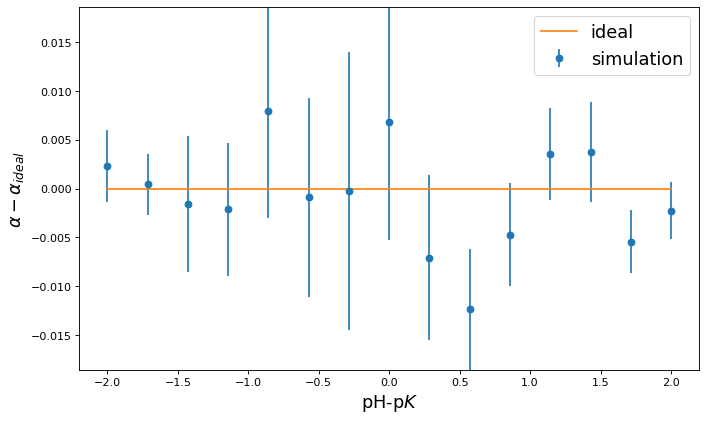

In [21]:
# plot the deviations from the ideal result
plt.figure(figsize=(10, 6), dpi=80)
ylim = np.amax(abs(av_alpha-ideal_alpha(pHs, pK)))
plt.ylim((-1.5*ylim, 1.5*ylim))
plt.errorbar(pHs - pK, av_alpha-ideal_alpha(pHs, pK),
             err_alpha, marker='o', linestyle='none', label=r"simulation")
plt.plot(pHs - pK, 0.0*ideal_alpha(pHs, pK), label=r"ideal")
plt.xlabel('pH-p$K$', fontsize=16)
plt.ylabel(r'$\alpha - \alpha_{ideal}$', fontsize=16)
plt.legend(fontsize=16)
plt.show()

### The Neutralizing Ion $\mathrm{B^+}$
Up to now we did not discuss the chemical nature the neutralizer $\mathrm{B^+}$. Due to the fact that we heavily coarse-grain and simulate both water and (most) $\mathrm{H^+}$-ions implicitly, it is not obvious how to best interpret the $\mathrm{B^+}$ chemically. 
Following is a discussion on how to interpret the $\mathrm{B^+}$-ion for different systems and pH-values. The added salt is not relevant in this context, therefore we omit it from the discussion. 

The simplest case to consider is what happens if you add the acidic polymer to pure water ($\mathrm{pH} = 7$). Some of the acid groups dissociate and release $\mathrm{H^+}$ ions into the solution. The pH decreases to a value that depends on $\mathrm{p}K_{\mathrm{A}}$ and on the concentration of ionizable groups. Now, three ionic species are present in the solution: $\mathrm{H^+}$, $\mathrm{A^-}$, and $\mathrm{OH^-}$. Because the reaction generates only one $\mathrm{B^+}$ ion in the simulation box, we conclude that in this case the $\mathrm{B^+}$ ions correspond to $\mathrm{H^+}$ ions. The $\mathrm{H^+}$ ions neutralize both the $\mathrm{A^-}$ and the $\mathrm{OH^-}$ ions. At acidic pH there are only very few $\mathrm{OH^-}$ ions and nearly all $\mathrm{H^+}$ ions act as a neutralizer for the $\mathrm{A^-}$ ions. Therefore, the concentration of $\mathrm{B^+}$ is very close to the concentration of $\mathrm{H^+}$ in the real aqueous solution. Only very few $\mathrm{OH^-}$ ions, and the $\mathrm{H^+}$ ions needed to neutralize them, are missing in the simulation box, when compared to the real solution.

To achieve a more acidic pH (with the same pK and polymer concentration), we need to add an acid to the system. We can do that by adding a strong acid, such as $\mathrm{HCl}$ or $\mathrm{HNO}_3$. We will denote this acid by a generic name $\mathrm{HX}$ to emphasize that in general its anion can be different from the salt anion $\mathrm{Cl^{-}}$. Now, there are 4 ionic species in the solution:  $\mathrm{H^+}$, $\mathrm{A^-}$, $\mathrm{OH^-}$, and $\mathrm{X^-}$ ions. By the same argument as before, we conclude that $\mathrm{B^+}$ ions correspond to $\mathrm{H^+}$ ions. The $\mathrm{H^+}$ ions neutralize the $\mathrm{A^-}$, $\mathrm{OH^-}$, and the $\mathrm{X^-}$ ions. Because the concentration of $\mathrm{X^-}$ is not negligible anymore, the concentration of $\mathrm{B^+}$ in the simulation box differs from the $\mathrm{H^+}$ concentration in the real solution. Now, many more ions are missing in the simulation box, as compared to the real solution: Few $\mathrm{OH^-}$ ions, many $\mathrm{X^-}$ ions, and all the $\mathrm{H^+}$ ions that neutralize them.

To achieve a neutral pH we need to add some base to the system to neutralize the polymer.
In the simplest case we add an alkali metal hydroxide, such as $\mathrm{NaOH}$ or $\mathrm{KOH}$, that we will generically denote as $\mathrm{MOH}$. Now, there are 4 ionic species in the solution:  $\mathrm{H^+}$, $\mathrm{A^-}$, $\mathrm{OH^-}$, and $\mathrm{M^+}$. In such situation, we can not clearly attribute a specific chemical identity to the $\mathrm{B^+}$ ions. However, only very few $\mathrm{H^+}$ and $\mathrm{OH^-}$ ions are present in the system at $\mathrm{pH} = 7$. Therefore, we can make the approximation that at this pH, all $\mathrm{A^-}$ are neutralized by the $\mathrm{M^+}$ ions, and the $\mathrm{B^+}$ correspond to $\mathrm{M^+}$. Then, the concentration of $\mathrm{B^+}$ also corresponds to the concentration of $\mathrm{M^+}$ ions. Now, again only few ions are missing in the simulation box, as compared to the real solution: Few $\mathrm{OH^-}$ ions, and few $\mathrm{H^+}$ ions.

To achieve a basic pH we need to add even more base to the system to neutralize the polymer.
Again, there are 4 ionic species in the solution:  $\mathrm{H^+}$, $\mathrm{A^-}$, $\mathrm{OH^-}$, and $\mathrm{M^+}$ and we can not clearly attribute a specific chemical identity to the $\mathrm{B^+}$ ions. Because only very few $\mathrm{H^+}$ ions should be present in the solution, we can make the approximation that at this pH, all $\mathrm{A^-}$ ions are neutralized by the $\mathrm{M^+}$ ions, and therefore $\mathrm{B^+}$ ions in the simulation correspond to $\mathrm{M^+}$ ions in the real solution. Because additional $\mathrm{M^+}$ ions in the real solution neutralize the $\mathrm{OH^-}$ ions, the concentration of $\mathrm{B^+}$ does not correspond to the concentration of $\mathrm{M^+}$ ions. Now, again many ions are missing in the simulation box, as compared to the real solution: Few $\mathrm{H^+}$ ions, many $\mathrm{OH^-}$ ions, and a comparable amount of the $\mathrm{M^+}$ ions.

To further illustrate this subject, we compare the concentration of the neutralizer ion $\mathrm{B^+}$ calculated in the simulation with the expected number of ions of each species. At a given pH and pK we can calculate the expected degree of ionization from the Henderson Hasselbalch equation. Then we apply the electroneutrality condition 
$$c_\mathrm{A^-} + c_\mathrm{OH^-} + c_\mathrm{X^-} = c_\mathrm{H^+} + c_\mathrm{M^+}$$
where we use either $c_\mathrm{X^-}=0$ or $c_\mathrm{M^+}=0$ because we always only add extra acid or base, but never both. Adding both would be equivalent to adding extra salt $\mathrm{MX}$.
We obtain the concentrations of $\mathrm{OH^-}$ and $\mathrm{H^+}$ from the input pH value, and substitute them to the electroneutrality equation to obtain
$$\alpha c_\mathrm{acid} + 10^{-(\mathrm{p}K_\mathrm{w} - \mathrm{pH})} + 10^{-\mathrm{pH}} = c_\mathrm{M^+} - c_\mathrm{X^-}$$
Depending on whether the left-hand side of this equation is positive or negative we know whether we should add $\mathrm{M^+}$ or $\mathrm{X^-}$ ions.

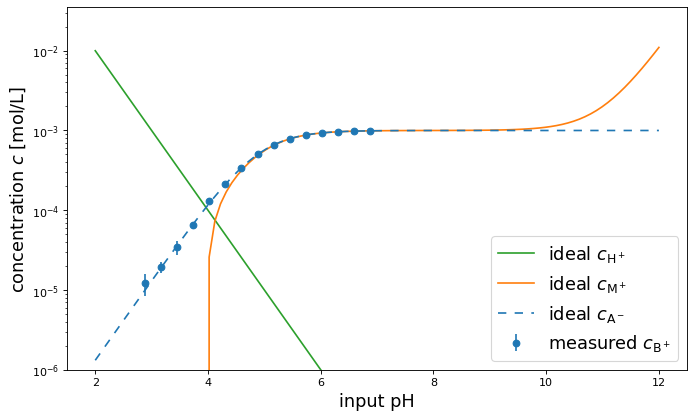

In [22]:
# average concentration of B+ is the same as the concentration of A-
av_c_Bplus = av_alpha * C_ACID_DIMENSIONLESS
err_c_Bplus = err_alpha * C_ACID_DIMENSIONLESS  # error in the average concentration

full_pH_range = np.linspace(2, 12, 100)
ideal_c_Aminus = ideal_alpha(full_pH_range, pK) * C_ACID_DIMENSIONLESS
ideal_c_OH = np.power(10.0, -(pKw - full_pH_range))
ideal_c_H = np.power(10.0, -full_pH_range)
# ideal_c_M is calculated from electroneutrality
ideal_c_M = np.clip((ideal_c_Aminus + ideal_c_OH - ideal_c_H), 0, np.inf)

# plot the simulation results compared with the ideal results of the cations
plt.figure(figsize=(10, 6), dpi=80)
plt.errorbar(pHs,
             av_c_Bplus,
             err_c_Bplus,
             marker='o', c="tab:blue", linestyle='none',
             label=r"measured $c_{\mathrm{B^+}}$", zorder=2)
plt.plot(full_pH_range, ideal_c_H, c="tab:green",
         label=r"ideal $c_{\mathrm{H^+}}$", zorder=0)
plt.plot(full_pH_range, ideal_c_M, c="tab:orange",
         label=r"ideal $c_{\mathrm{M^+}}$", zorder=0)
plt.plot(full_pH_range, ideal_c_Aminus, c="tab:blue", ls=(0, (5, 5)),
         label=r"ideal $c_{\mathrm{A^-}}$", zorder=1)
plt.yscale("log")
plt.ylim(1e-6,)
plt.xlabel('input pH', fontsize=16)
plt.ylabel(r'concentration $c$ $[\mathrm{mol/L}]$', fontsize=16)
plt.legend(fontsize=16)
plt.show()

The plot shows that at intermediate pH the concentration of $\mathrm{B^+}$ ions is approximately equal to the concentration of $\mathrm{M^+}$ ions. Only at one specific $\mathrm{pH}$ the concentration of $\mathrm{B^+}$ ions is equal to the concentration of $\mathrm{H^+}$ ions. This is the pH one obtains when dissolving the weak acid $\mathrm{A}$ in pure water.

In an ideal system, the ions missing in the simulation have no effect on the ionization degree. In an interacting system, the presence of ions in the box affects the properties of other parts of the system. Therefore, in an interacting system this discrepancy is harmless only at intermediate pH. The effect of the small ions on the rest of the system can be estimated from the overall the ionic strength.
$$ I = \frac{1}{2}\sum_i c_i z_i^2 $$

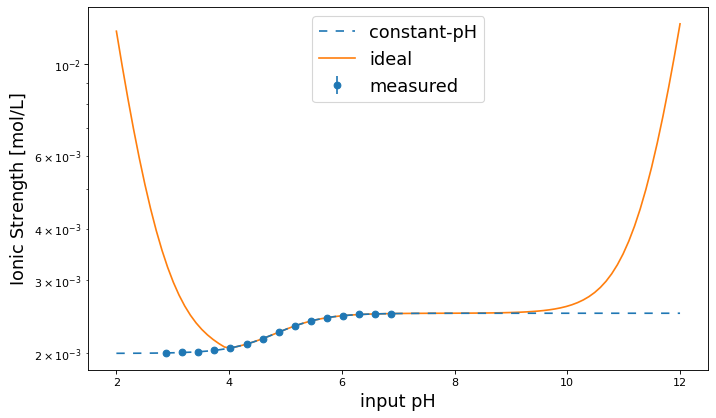

In [23]:
ideal_c_X = np.clip(-(ideal_c_Aminus + ideal_c_OH - ideal_c_H), 0, np.inf)

ideal_ionic_strength = 0.5 * \
    (ideal_c_X + ideal_c_M + ideal_c_H + ideal_c_OH + 2 * C_SALT_DIMENSIONLESS)
# in constant-pH simulation ideal_c_Aminus = ideal_c_Bplus
cpH_ionic_strength = 0.5 * (ideal_c_Aminus + 2 * C_SALT_DIMENSIONLESS)
cpH_ionic_strength_measured = 0.5 * (av_c_Bplus + 2 * C_SALT_DIMENSIONLESS)
cpH_error_ionic_strength_measured = 0.5 * err_c_Bplus

plt.figure(figsize=(10, 6), dpi=80)
plt.errorbar(pHs,
             cpH_ionic_strength_measured,
             cpH_error_ionic_strength_measured,
             c="tab:blue",
             linestyle='none', marker='o',
             label=r"measured", zorder=3)
plt.plot(full_pH_range,
         cpH_ionic_strength,
         c="tab:blue",
         ls=(0, (5, 5)),
         label=r"constant-pH", zorder=2)
plt.plot(full_pH_range,
         ideal_ionic_strength,
         c="tab:orange",
         linestyle='-',
         label=r"ideal", zorder=1)


plt.yscale("log")
plt.xlabel('input pH', fontsize=16)
plt.ylabel(r'Ionic Strength [$\mathrm{mol/L}$]', fontsize=16)
plt.legend(fontsize=16)
plt.show()

We see that the ionic strength in the simulation box significantly deviates from the ionic strength of the real solution only at high or low pH value. If the $\mathrm{p}K_{\mathrm{A}}$ value is sufficiently large, then the deviation at very low pH can also be neglected because then the polymer is uncharged in the region where the ionic strength is not correctly represented in the cpH simulation. At a high pH the ionic strength will have an effect on the weak acid, because then it is fully charged. The pH range in which the constant-pH method uses approximately the right ionic strength depends on salt concentration, weak acid concentration and the $\mathrm{p}K_{\mathrm{A}}$ value. See also [Landsgesell2019](https://doi.org/10.1039/C8SM02085J) for a more detailed discussion of this issue, and its consequences.


## Suggested problems for further work

* Try changing the concentration of ionizable species in the non-interacting system. You should observe that it does not affect the obtained titration.

* Try changing the number of samples and the number of particles to see how the estimated error and the number of uncorrelated samples will change. Be aware that if the number of uncorrelated samples is low, the error estimation is too optimistic.

* Try running the same simulations with steric repulsion and then again with electrostatic interactions. Observe how the ionization equilibrium is affected by various interactions. Warning: simulations with electrostatics are much slower. If you want to obtain your results more quickly, then decrease the number of pH values.

## References

[Janke2002](https://www.physik.uni-leipzig.de/~janke/Paper/nic10_423_2002.pdf) Janke W. Statistical Analysis of Simulations: Data Correlations and Error Estimation,
In Quantum Simulations of Complex Many-Body Systems: From Theory to Algorithms, Lecture Notes,
J. Grotendorst, D. Marx, A. Muramatsu (Eds.), John von Neumann Institute for Computing, Jülich,
NIC Series, Vol. 10, ISBN 3-00-009057-6, pp. 423-445, 2002.

[Landsgesell2019](https://doi.org/10.1039/C8SM02085J) Landsgesell, J.; Nová, L.; Rud, O.; Uhlík, F.; Sean, D.; Hebbeker, P.; Holm, C.; Košovan, P. Simulations of Ionization Equilibria in Weak Polyelectrolyte Solutions and Gels. Soft Matter 2019, 15 (6), 1155–1185. 
    
[Reed1992](https://doi.org/10.1063/1.462145) Reed, C. E.; Reed, W. F. Monte Carlo Study of Titration of Linear Polyelectrolytes. The Journal of Chemical Physics 1992, 96 (2), 1609–1620.

[Smith1994](https://doi.org/10.1063/1.466443) Smith, W. R.; Triska, B. The Reaction Ensemble Method for the Computer Simulation of Chemical and Phase Equilibria. I. Theory and Basic Examples. The Journal of Chemical Physics 1994, 100 (4), 3019–3027.